In [69]:
%%time
# Version
exp_version = 'v5.3'  
# Experiment version

data_prep = 'full'  # full = data transformation, representation, std = standard, only dummy encode
var_set = 'all'  # all = all vars, fs = top fisher score, pca = first PCs
fname = '_' + data_prep + '_' + var_set + '_' + exp_version  # Name of output file
print(fname)

_full_all_v5.3
CPU times: total: 0 ns
Wall time: 1 ms


In [70]:
%%time
###################################################################
# MODIFY THESE FLAGS TO TURN ON/OFF THE DATA PROCESSING FUNCTIONS #
###################################################################

# Flag variables to run the data processing steps
# Feature engineering step
enable_num_poly = True  # Add polynomial terms
# Value transformation step
enable_trans_cat_dt = True  # Remapping cat variables - Decision tree–based remapping
enable_trans_num_dt = True  # Discretizing num variables - Decision tree–based discretization
enable_trans_num_ef = True  # Discretizing num variables - Equal frequency discretization
enable_trans_num_ew = True  # Discretizing num variables - Equal width discretization
# Value representation step
enable_repr_dummy = True  # Represent cat variables - Dummy coding
enable_repr_icd = True  # Represent cat variables - Incidence (of target variable) replacement
enable_repr_woe = True  # Represent cat variables - Weight-of-Evidence (WoE) conversion
drop_cat_vars = True  # Drop cat variables after value representation step
# Other data processing
enable_normalize = True  # Normalize the data to the same range [0, 1]

CPU times: total: 0 ns
Wall time: 0 ns


## Initiation

In [310]:
%%time
# Data exploration
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing
import pickle
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Modeling
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix

# Experimental setup
from sklearn.model_selection import KFold, cross_validate, GridSearchCV,cross_val_score,RepeatedStratifiedKFold,RandomizedSearchCV,ShuffleSplit
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve

CPU times: total: 0 ns
Wall time: 1e+03 µs


In [72]:
def benchmark(models,model_name,X_train,y_train,cv):
    
    measures = pd.DataFrame()
    AUC_test = []
    AUC_train = []
    Score_test = []
    Score_train =[]

    for model,name in zip(models,model_name): 
        AUC_v = cross_validate(model, X_train, y_train, scoring='roc_auc', cv=cv,return_train_score=True)
        AUC_test=AUC_v["test_score"].mean()
        AUC_train=AUC_v["train_score"].mean()
        Score_v = cross_validate(model, X_train, y_train, scoring='f1', cv=cv,return_train_score=True)
        Score_test=Score_v["test_score"].mean()
        Score_train=Score_v["train_score"].mean()
        measures[name] = [AUC_test, Score_test,AUC_train,Score_train]
        measures.index =['Test AUC Score', 'Test F1 score','Train AUC Score', 'Train F1 score']
    return measures

In [311]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

## 1. Data summary

#### (a) Read and print out some data

In [73]:
%%time
# Read train, test
train = pd.read_csv('./data/processed/g1/bank_mkt_train.csv', low_memory=False)
test = pd.read_csv('./data/processed/g1/bank_mkt_test.csv', low_memory=False)

CPU times: total: 125 ms
Wall time: 122 ms


In [74]:
%%time
# Print out to check the data
print(train.dtypes.value_counts())
train.head()

object     10
float64     9
int64       2
dtype: int64
CPU times: total: 0 ns
Wall time: 2 ms


,client_id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribe
0,29925,42.0,management,married,basic.9y,no,no,no,cellular,jul,...,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0
1,37529,35.0,unemployed,married,university.degree,no,yes,no,telephone,jun,...,4.0,999.0,0.0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,0
2,2757,44.0,technician,married,basic.9y,no,yes,yes,cellular,may,...,1.0,999.0,0.0,nonexistent,-1.8,92.893,-46.2,1.264,5099.1,0
3,9642,45.0,services,married,high.school,no,yes,no,cellular,apr,...,1.0,999.0,0.0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,0
4,14183,45.0,unknown,married,unknown,unknown,unknown,unknown,telephone,may,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,0


#### (b) Create a list of column names to manage variables

In [75]:
%%time
# General list of variables
id_var = ["client_id"]  # ID
target_var = ["subscribe"]  # Target get variable
predictors = [v for v in train.columns if v not in id_var + target_var]

# List of numerical and catergorical variables
num_vars = ['age', 'campaign', 'pdays', 'previous',
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan',
            'contact', 'month', 'day_of_week',
            'poutcome']

# Double check the list of variables
assert(len(predictors) == len(num_vars) + len(cat_vars))

CPU times: total: 0 ns
Wall time: 0 ns


#### (c) Check the target variable class distribution

In [76]:
%%time
# By number
print(train[target_var].value_counts())

# By percentage
print(train[target_var].value_counts(normalize=True))

subscribe
0            17729
1             2271
dtype: int64
subscribe
0            0.88645
1            0.11355
dtype: float64
CPU times: total: 15.6 ms
Wall time: 10 ms


## 2. Processing data

### 2.1. Error, data correction

#### (a) Check and correct data error - Constant variables


In [77]:
%%time
# Count number of unique values of each variable
vars_nunique = train[num_vars + cat_vars].apply(pd.Series.nunique, dropna=False, axis=0)
cont_vars = vars_nunique.index[vars_nunique < 2].tolist()

# Update train, test
train = train[id_var + num_vars + cat_vars + target_var]
test = test[id_var + num_vars + cat_vars]

CPU times: total: 31.2 ms
Wall time: 30 ms


#### (b) Check and correct data error - Missing values

In [78]:
%%time
# Check missing value
print('Train - # NA of num vars:', train[num_vars].isna().sum().sum())
print('Train - # NA of cat vars:', train[cat_vars].isna().sum().sum())
print('Test - # NA of num vars:', test[num_vars].isna().sum().sum())
print('Test - # NA of cat vars:', test[cat_vars].isna().sum().sum())

Train - # NA of num vars: 1730
Train - # NA of cat vars: 1934
Test - # NA of num vars: 918
Test - # NA of cat vars: 1057
CPU times: total: 62.5 ms
Wall time: 72 ms


In [79]:
%%time
# Here, we test the effect of dropping variables with high missing percentage (>30%)
na_threshold = 0.3

# Drop num variables with more than 30% missing values
num_na_pct = train[num_vars].isnull().mean()
num_vars = num_na_pct[num_na_pct <= na_threshold].index.tolist()
print("Drop num variables with high missing pct:", num_na_pct[num_na_pct > na_threshold].tolist())

# Drop cat variables with more than 30% missing values
cat_na_pct = train[cat_vars].isnull().mean()
cat_vars = cat_na_pct[cat_na_pct <= 0.3].index.tolist()
print("Drop cat variables with high missing pct:", cat_na_pct[cat_na_pct > na_threshold].tolist())

Drop num variables with high missing pct: []
Drop cat variables with high missing pct: []
CPU times: total: 46.9 ms
Wall time: 47 ms


In [80]:
%%time

na_vars = []
# Numerical variables
# Build the missing value imputor using the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp.fit(train[num_vars])

# Reconstruct the list of vars + indicators
na_vars = na_vars + [num_vars[v] + "_na" for v in imp.indicator_.features_]
impute_vars = num_vars + na_vars

# Apply on train, test
train[impute_vars] = pd.DataFrame(imp.transform(train[num_vars]), columns=impute_vars)
test[impute_vars] = pd.DataFrame(imp.transform(test[num_vars]), columns=impute_vars)

CPU times: total: 62.5 ms
Wall time: 44 ms


In [81]:
%%time
# Categorical variables
# Impute missing value using a new category "Missing"
train[cat_vars] = train[cat_vars].fillna('Missing')
test[cat_vars] = test[cat_vars].fillna('Missing')

CPU times: total: 93.8 ms
Wall time: 121 ms


#### (c) Check and correct data error - Outliers in numerical variables

In [82]:
%%time
# Check the outliers on train, test
for v in num_vars:
    # Calculate the boundaries on train [mean-3*sd, mean+3*sd]
    mu = np.mean(train[v])
    sd = np.std(train[v])
    lower = mu - 3*sd
    upper = mu + 3*sd
    # Check outliers using the boundaries
    train_out = (train[v] < lower) | (train[v] > upper)
    test_out = (test[v] < lower) | (test[v] > upper)
    if np.sum(train_out) + np.sum(test_out) > 0:
        print(v, "has # outliers on train, test :",
              np.sum(train_out), "[", np.round(100*np.mean(train_out), 2), "% ]",
              np.sum(test_out), "[", np.round(100*np.mean(test_out), 2), "% ]")

age has # outliers on train, test : 181 [ 0.9 % ] 89 [ 0.89 % ]
campaign has # outliers on train, test : 423 [ 2.11 % ] 210 [ 2.1 % ]
pdays has # outliers on train, test : 750 [ 3.75 % ] 371 [ 3.71 % ]
previous has # outliers on train, test : 519 [ 2.6 % ] 269 [ 2.69 % ]
CPU times: total: 15.6 ms
Wall time: 21 ms


#### (d) Encode categorical variables

In [83]:
# %%time
# # Keep top 10 categories and combine minor categories into "Others"
# for v in cat_vars:
#     # Find the top 10 categories per cat variable
#     top10_cat = train[v].value_counts()[:10].index.tolist()
#     # Impute on train, test
#     train[v][-train[v].isin(top10_cat)] = 'Others'
#     test[v][-test[v].isin(top10_cat)] = 'Others'

In [84]:
%%time
# Encode categorical variables as integer values
# Categorical variables in any format will be converted to string
enc = OrdinalEncoder()
enc.fit(pd.concat([train[cat_vars].astype(str), test[cat_vars].astype(str)], axis=0))
# Apply on train, test
train[cat_vars] = enc.transform(train[cat_vars].astype(str))
test[cat_vars] = enc.transform(test[cat_vars].astype(str))

CPU times: total: 141 ms
Wall time: 144 ms


#### (e) Finalize the processed data

Current lists of variables:
- id_var : customer ID
- num_vars : numerical variables
- cat_vars : categorical variables
- na_vars : indicators for tracking missing values, bool [False, True]
- target_var : target variable, churn [0, 1]

In [85]:
%%time
# Convert bool variable to int
train[na_vars] = train[na_vars].astype(np.int8)
test[na_vars] = test[na_vars].astype(np.int8)

CPU times: total: 31.2 ms
Wall time: 45 ms


In [86]:
%%time
# Print out the final variables
print("# id_var [", len(id_var), "] :", id_var)
print("# num_vars [", len(num_vars), "] :", num_vars[:5], "...")
print("# cat_vars [", len(cat_vars), "] :", cat_vars[:5], "...")
print("# na_vars [", len(na_vars), "] :", na_vars[:5], "...")
print("# target_var [", len(target_var), "] :", target_var)

# id_var [ 1 ] : ['client_id']
# num_vars [ 9 ] : ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate'] ...
# cat_vars [ 10 ] : ['job', 'marital', 'education', 'default', 'housing'] ...
# na_vars [ 9 ] : ['age_na', 'campaign_na', 'pdays_na', 'previous_na', 'emp.var.rate_na'] ...
# target_var [ 1 ] : ['subscribe']
CPU times: total: 0 ns
Wall time: 997 µs


In [87]:
%%time
# Sort the data according to the variables list
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(20000, 30)
(10000, 29)
CPU times: total: 0 ns
Wall time: 6.99 ms


### 2.2. Feature engineering

#### (a) Quickly detect most (potentially) important varriables - Correlation test for numerical variables

In [88]:
%%time
# Pearson's correlation for numerical variables
corr = train[num_vars + target_var].corr(method='pearson')
corr = corr[target_var[0]][:-1].dropna().sort_values(ascending=False)
print("Top 5 vars [+] correlated with target_var :"); print(corr[corr > 0][:5])
print("Top 5 vars [-] correlated with target_var :"); print(corr[corr < 0][-5:])

Top 5 vars [+] correlated with target_var :
previous         0.235584
cons.conf.idx    0.055546
age              0.034892
Name: subscribe, dtype: float64
Top 5 vars [-] correlated with target_var :
cons.price.idx   -0.137655
emp.var.rate     -0.298583
euribor3m        -0.307895
pdays            -0.332565
nr.employed      -0.354529
Name: subscribe, dtype: float64
CPU times: total: 15.6 ms
Wall time: 18 ms


#### (c) Add polynomial terms for numerical variables

<u>Note:</u> We only add the polynomial terms (degree=3) for a num variable if it increases the LR model performance.

In [89]:
%%time
if enable_num_poly:
    for v in num_vars:
        # Setup the LR model
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = LogisticRegression(max_iter=200)
        parameters = {}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        
        # Fit the LR model for 1 numerical variable
        clf.fit(train[[v]], train[target_var].squeeze())
        clf_num_score = clf.best_score_
        
        # Fit the LR model for 1 numerical variable + it polynomial degree = 3
        poly = PolynomialFeatures(degree=3, include_bias=False)
        poly.fit(train[[v]])
        clf.fit(poly.transform(train[[v]]), train[target_var].squeeze())
        clf_poly_score = clf.best_score_
        
        # Add the polynomial terms to train, test
        if (clf_poly_score > 0.5) & (clf_poly_score - clf_num_score > 0.05):
            print('Variable', v, 'AUC vs. AUC poly:', clf_num_score, '-->', clf_poly_score)
            poly_vars = [v_poly.replace('x0', v) for v_poly in poly.get_feature_names_out()[1:]]
            num_vars = num_vars + poly_vars
            train[poly_vars] = pd.DataFrame(poly.transform(train[[v]])[:, 1:], columns=poly_vars)
            test[poly_vars] = pd.DataFrame(poly.transform(test[[v]])[:, 1:], columns=poly_vars)

Variable age AUC vs. AUC poly: 0.49299075190162284 --> 0.5908793357880742
CPU times: total: 1.36 s
Wall time: 6.51 s


### 2.3. Value transformation (num, cat => cat)

#### 2.3.1. Remapping categorical variables - Decision tree–based remapping

#### (a) Apply the variable remmaping for all categorical variables

In [90]:
%%time
# List of variables to track the value transformation process
trans_vars = []

if enable_trans_cat_dt:
    for v in cat_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Remapping variable", v,
                  "from", train[[v]].nunique().values[0],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_remap'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

Remapping variable job from 13 to 11 categories
Remapping variable marital from 5 to 3 categories
Remapping variable education from 9 to 7 categories
Remapping variable default from 4 to 3 categories
Remapping variable housing from 4 to 2 categories
Remapping variable contact from 3 to 3 categories
Remapping variable month from 11 to 9 categories
Remapping variable day_of_week from 6 to 2 categories
Remapping variable poutcome from 4 to 3 categories
CPU times: total: 2.42 s
Wall time: 2.92 s


#### 2.3.2. Discretizing (or binning) numerical variables - Equal frequency discretization

#### (a) Apply the variable discretizing for all numerical variables

In [91]:
%%time
if enable_trans_num_ef:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        est.fit(train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binef_var = v + '_binef'
            trans_vars.append(binef_var)
            train[binef_var] = est.transform(train[[v]])
            test[binef_var] = est.transform(test[[v]])

CPU times: total: 172 ms
Wall time: 178 ms


C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are re

#### 2.3.3. Finalize value transformation

- Finalize the variables list
- Arrange the data columns

<u>Note:</u> After the end of the value transformation step, we have these final lists of variables to manage:
- num_vars
- na_vars
- cat_vars = cat_vars + trans_vars

In [92]:
%%time
# Finalize the variable list
cat_vars = cat_vars + trans_vars
print("Transformed num, cat variables into # new categorical variables :", len(trans_vars))

Transformed num, cat variables into # new categorical variables : 19
CPU times: total: 0 ns
Wall time: 0 ns


In [93]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(test.shape)

(20000, 51)
(10000, 50)
CPU times: total: 15.6 ms
Wall time: 18 ms


### 2.4. Value representation (cat => num)


In [94]:
%%time
# List of variables to track the value representation process
repr_vars = []
dummy_vars = []

CPU times: total: 0 ns
Wall time: 0 ns


#### 2.4.1. Dummy coding

#### (a) Apply the value representation for all categorical variables

In [95]:
%%time
if enable_repr_dummy:
    # Create dummy variables, drop the first dummy column
    enc = OneHotEncoder(drop="first", handle_unknown="error")
    enc.fit(pd.concat([train[cat_vars], test[cat_vars]], axis=0))
    dummy_vars = enc.get_feature_names_out().tolist()
    repr_vars = repr_vars + dummy_vars
    # Transform train, test
    train_dummy = enc.transform(train[cat_vars])
    test_dummy = enc.transform(test[cat_vars])

CPU times: total: 219 ms
Wall time: 217 ms


#### 2.4.2. Incidence (of target variable) replacement

#### (a) Apply the value representation for all categorical variables

In [96]:
%%time
if enable_repr_icd:
    for v in cat_vars:
        # Find the incidence rates per category of a categorical variable
        tb = pd.pivot_table(train, values=target_var, index=v, aggfunc=np.mean).reset_index()
        icd_var = v + "_icd"
        repr_vars.append(icd_var)
        tb.columns = [v, icd_var]
        # Add the incidence column to train, test
        train[icd_var] = pd.merge(train[[v]], tb, on=v)[icd_var]
        test[icd_var] = pd.merge(test[[v]], tb, on=v)[icd_var]

CPU times: total: 906 ms
Wall time: 885 ms


#### 2.4.3. Weight-of-Evidence (WoE) conversion

#### (a) Apply the value representation for all categorical variables

In [97]:
%%time
if enable_repr_woe:
    for v in cat_vars:
        # Find the WoE per category of a categorical variable
        tb = train[[v] + target_var].value_counts().unstack(fill_value=0).reset_index()
        woe_var = v + "_woe"
        repr_vars.append(woe_var)
        e = 1e-10  # Small value
        tb[woe_var] = np.log((tb[1] + e) / (tb[0] + e))
        # Add the incidence column to train, test
        train[woe_var] = pd.merge(train[[v]], tb[[v, woe_var]], on=v)[woe_var]
        test[woe_var] = pd.merge(test[[v]], tb[[v, woe_var]], on=v)[woe_var]

CPU times: total: 1.11 s
Wall time: 1.12 s


#### 2.4.3. Finalize value representation 

#### (a) Drop categorical variables, add dummy variables

In [98]:
%%time
# Drop cat vars
if drop_cat_vars:
    train = train.drop(cat_vars, axis=1)
    test = test.drop(cat_vars, axis=1)
    cat_vars = []

CPU times: total: 46.9 ms
Wall time: 39 ms


In [99]:
%%time
# Add dummy variables
if enable_repr_dummy:
    train = pd.concat([train, pd.DataFrame(train_dummy.toarray(), columns=dummy_vars)], axis=1)
    test = pd.concat([test, pd.DataFrame(test_dummy.toarray(), columns=dummy_vars)], axis=1)
    del train_dummy, test_dummy

CPU times: total: 78.1 ms
Wall time: 75 ms


#### (b) Impute missing values created by value representation

In [100]:
%%time
# Impute new missing values on test using the mean on train
if len(repr_vars) > 0:
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    imp.fit(train[repr_vars])
    test[repr_vars] = pd.DataFrame(imp.transform(test[repr_vars]), columns=repr_vars)

CPU times: total: 1.19 s
Wall time: 1.17 s


#### (c) Finalize the variables list

In [101]:
%%time
# Combine the variable list
num_vars = num_vars + repr_vars
print("Represented cat variables with # new num variables :", len(repr_vars))

Represented cat variables with # new num variables : 208
CPU times: total: 0 ns
Wall time: 0 ns


In [102]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + na_vars + target_var]
test = test[id_var + num_vars + na_vars]
print(train.shape)
print(test.shape)

(20000, 230)
(10000, 229)
CPU times: total: 62.5 ms
Wall time: 58 ms


### 2.5. Other data processing

####  (a) Filter out again low variance variables (or constant)

In [103]:
%%time
# List of all predictors
predictors = num_vars + na_vars

CPU times: total: 0 ns
Wall time: 0 ns


In [104]:
%%time
# Detect constant vars
sel = VarianceThreshold(0)  # Var = 0 by default
sel.fit(train[predictors])
const_vars = [predictors[i] for i in np.where(sel.variances_ == 0)[0]]
predictors = [v for v in predictors if v not in const_vars]

# Drop from train, test
print('Drop # constant vars :', len(const_vars))
train = train.drop(const_vars, axis=1)
test = test.drop(const_vars, axis=1)

Drop # constant vars : 0
CPU times: total: 156 ms
Wall time: 164 ms


####  (b) scale numeric variables

In [105]:
##### (a) Data normalization - Numerical variables
%time
if enable_normalize:
    for v in num_vars:
        # Build the normalizer on train
        scaler = MinMaxScaler().fit(train[[v]])
        # Apply on train, test
        train[v] = scaler.transform(train[[v]])
        test[v] = scaler.transform(test[[v]])

CPU times: total: 0 ns
Wall time: 0 ns


#### (c) Drop duplicated variables

Sometime, the data processing process can create a lot of duplicated variables. In this case, it is necessary to identify and drop them.

In [106]:
%%time
# Count the duplicated vars
dup_vars = train[predictors].T.duplicated()
print('# duplicated vars :', dup_vars.sum())

# duplicated vars : 53
CPU times: total: 3.61 s
Wall time: 3.61 s


In [107]:
%%time
# Drop the duplicated vars from train, test
predictors = [predictors[i] for i in range(0, len(predictors)) if not dup_vars[i]]
train = train[id_var + predictors + target_var]
test = test[id_var + predictors]

CPU times: total: 46.9 ms
Wall time: 48 ms


#### (d) Export the processed data to file

In [108]:
%%time
# Print out the data to check
print(train.shape)
print(test.shape)

(20000, 177)
(10000, 176)
CPU times: total: 0 ns
Wall time: 0 ns


In [109]:
%%time
# Save to pickle format
train.to_pickle("./data/processed/final/" + fname + ".pkl")
test.to_pickle("./data/processed/final/" + fname + ".pkl")

CPU times: total: 46.9 ms
Wall time: 44 ms


### 2.6. Variable selection

####  (a) Variable selection: Fisher Score

In [110]:
%%time
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

CPU times: total: 0 ns
Wall time: 0 ns


In [111]:
%%time
# Calculate Fisher Score for all variable
fs = FisherScore(train, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head(50)

CPU times: total: 578 ms
Wall time: 570 ms


,predictor,fisherscore
8,nr.employed,0.738579
7,euribor3m,0.701092
4,emp.var.rate,0.669549
87,emp.var.rate_binef_4.0,0.596566
2,pdays,0.465701
63,poutcome_3.0,0.448828
115,nr.employed_binef_4.0,0.412251
3,previous,0.385756
83,previous_binef_1.0,0.383010
62,poutcome_2.0,0.373415


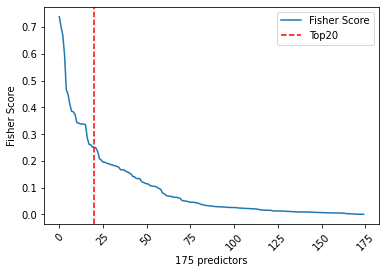

CPU times: total: 203 ms
Wall time: 191 ms


In [112]:
%%time
# Visualize the Fisher Score
plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axvline(x=20, linestyle='dashed', color='red')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', 'Top20'])
plt.show()

In [113]:
%%time
# Check how AUC change when add more variables: Top n vars
fs_scores = []
top_n_vars = 50
for i in range(1, top_n_vars+1):
    if i % 100 == 0: print('Added # top vars :', i)
    top_n_predictors = fs_df['predictor'][:i]
    clf = LogisticRegression()
    fs_scores.append(cross_validate(clf, train[top_n_predictors], train[target_var].values.squeeze(),
                                    scoring='roc_auc', cv=5, verbose=0, n_jobs=-1, return_train_score=True))

# How the AUC curve looks like when adding top vars
measures = pd.DataFrame()
for s,i in zip(fs_scores,range(1, top_n_vars+1)):
    train_score= s['train_score'].mean()
    test_score=s['test_score'].mean()
    measures[i] = [train_score, test_score]
    measures.index =['Train AUC Score', 'Test AUC score']


CPU times: total: 1.55 s
Wall time: 20.2 s


In [114]:
measures

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
Train AUC Score,0.746509,0.748537,0.755055,0.749795,0.756286,0.756386,0.773060,0.777387,0.777918,0.778150,...,0.795146,0.795333,0.795140,0.795575,0.796078,0.796081,0.796044,0.796180,0.796358,0.796381
Test AUC score,0.746588,0.749822,0.755051,0.749947,0.756203,0.756380,0.773075,0.776225,0.777440,0.777517,...,0.791452,0.791616,0.790953,0.791448,0.791542,0.791424,0.791458,0.791471,0.791529,0.791512


In [115]:
%%time
# Select the top variables based on Fisher Score
top_fs_vars = fs_df['predictor'].values[:top_n_vars]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 50
CPU times: total: 0 ns
Wall time: 0 ns


array(['nr.employed', 'euribor3m', 'emp.var.rate',
       'emp.var.rate_binef_4.0', 'pdays', 'poutcome_3.0',
       'nr.employed_binef_4.0', 'previous', 'previous_binef_1.0',
       'poutcome_2.0', 'emp.var.rate_binef_2.0', 'contact_2.0',
       'cons.conf.idx_binef_5.0', 'cons.conf.idx_binef_6.0',
       'nr.employed_binef_3.0', 'contact_1.0', 'cons.price.idx',
       'euribor3m_binef_5.0', 'nr.employed_binef_1.0', 'default_remap_4',
       'default_2.0', 'month_7.0', 'default_1.0',
       'cons.conf.idx_binef_7.0', 'month_9.0', 'month_6.0', 'month_10.0',
       'euribor3m_binef_8.0', 'cons.price.idx_binef_4.0',
       'cons.price.idx_binef_5.0', 'euribor3m_binef_4.0', 'job_2.0',
       'cons.price.idx_binef_2.0', 'cons.conf.idx_binef_2.0',
       'cons.price.idx_binef_6.0', 'job_6.0', 'age_binef_9.0', 'campaign',
       'emp.var.rate_binef_1.0', 'euribor3m_binef_9.0', 'age^3',
       'job_9.0', 'campaign_binef_3.0', 'cons.conf.idx_binef_3.0',
       'euribor3m_binef_7.0', 'month_1.0'

## 3. Modeling

In [116]:
%%time
# List of parameter tuning using cross validation for all models
model_grid = {}

CPU times: total: 0 ns
Wall time: 0 ns


In [117]:
%%time
#########################################################
# MODIFY THE BELOW VALUE TO SET THE TARGET VARIABLE SET #
#########################################################
var_set = 'fs'  # all = all vars, fs = top fisher score, pca = first PCs

# Prepare the data according to the selected set of variables
if var_set == 'all':
    X = train[predictors]
    X_test = test[predictors]
    test_id = test[id_var]
elif var_set == 'fs':
    X = train[top_fs_vars]
    X_test = test[top_fs_vars]
    test_id = test[id_var]
y = train[target_var].values.squeeze()
print(X.shape)

# Update output file name
fname = '_' + data_prep + '_' + var_set + str(X.shape[1]) + '_' + exp_version
print(fname)

# Remove unused data
# del train, test, train_pca, test_pca

(20000, 50)
_full_fs50_v5.3
CPU times: total: 15.6 ms
Wall time: 12 ms


### 3.1. Raw Modeling

In [172]:
lr = LogisticRegression()
rf = RandomForestClassifier()
sgd = SGDClassifier()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
ada = AdaBoostClassifier()
lgb = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# initiate the models 
models = [lr,rf,sgd,knn,dt,ada,lgb]
model_name  = ['Logistic Regression', 'Random Forest', 'Stochastic Gradient Descent','K-Nearest Neighbours','Decision Tree','Ada Boosting',"Light Gradient Boosted"]

In [173]:
comparison = benchmark(models,model_name,X,y,cv)
comparison

C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

,Logistic Regression,Random Forest,Stochastic Gradient Descent,K-Nearest Neighbours,Decision Tree,Ada Boosting,Light Gradient Boosted
Test AUC Score,0.791136,0.749473,0.747361,0.726135,0.622856,0.789442,0.792115
Test F1 score,0.332422,0.372892,0.320151,0.382938,0.331219,0.330522,0.368821
Train AUC Score,0.796167,0.997419,0.749035,0.925695,0.998343,0.799725,0.888333
Train F1 score,0.341052,0.920498,0.321533,0.498222,0.919793,0.343119,0.491054


In [182]:
# define pipeline
over = SMOTE(sampling_strategy=0.5)
X_resampled,y_resampled = over.fit_resample(X,y)

In [183]:
comparison_resampled = benchmark(models,model_name,X_resampled,y_resampled,cv)

C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

In [184]:
comparison_resampled

,Logistic Regression,Random Forest,Stochastic Gradient Descent,K-Nearest Neighbours,Decision Tree,Ada Boosting,Light Gradient Boosted
Test AUC Score,0.798709,0.943340,0.780548,0.887971,0.854795,0.877802,0.943836
Test F1 score,0.636573,0.839817,0.603807,0.746412,0.802671,0.711830,0.845036
Train AUC Score,0.800605,0.999150,0.781773,0.956375,0.999573,0.878816,0.959409
Train F1 score,0.637722,0.980577,0.604070,0.825829,0.980458,0.713391,0.867949


In [227]:
data = "normmal"

if data =="normal":
    X = X
    y = y
else: 
    X=X_resampled
    y=y_resampled

### 3.2. Hyperparameter Tunning

##### Stochastic Gradient Descent

In [228]:
# Define scoring matrices
scoring = {"AUC": "roc_auc", "F1":"f1"}

In [229]:
# define search space
space = dict()
space ["loss"] = ["hinge", "log","modified_huber"]
space["penalty"] =   ["l2", "l1","elasticnet"]
space["max_iter"]= [1000, 2000,3000,4000]

In [230]:
# define search
search_ada = RandomizedSearchCV(sgd, space, n_iter=60,scoring=scoring, n_jobs=-1, cv=10, random_state=1,refit="AUC",return_train_score=True)

In [231]:
# fit the model with cv and hyperparameter
sgd_result = search_ada.fit(X, y)

C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 36 is smaller than n_iter=60. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [232]:
# summarize result
print('Best F1-score: %s' % sgd_result.cv_results_["mean_test_F1"][sgd_result.best_index_])
print('Best AUC: %s' % sgd_result.best_score_)
print('Best Hyperparameters: %s' % sgd_result.best_params_)

Best F1-score: 0.6284591381890428
Best AUC: 0.7974941229234628
Best Hyperparameters: {'penalty': 'l2', 'max_iter': 1000, 'loss': 'log'}


In [233]:
sgd_final = SGDClassifier(penalty='l2', max_iter=1000, loss='log')
sgd_final=sgd_final.fit(X, y)

In [234]:
sgd_pred = sgd_final.predict_proba(X_test)
sgd_prob = pd.DataFrame(sgd_pred[:,1], columns=['subscribe'])

In [235]:
sgd_out = pd.concat([test_id,sgd_prob],axis=1, ignore_index=True)
sgd_out.rename(columns={0: 'client_id', 1: 'subscribe'}, inplace=True)
sgd_out.to_csv("./data/output/attempt_sgd.csv",index=False)

##### Logistic Regression

In [236]:
# define search space
space = dict()
space ["penalty"] = ['l1', 'l2','elasticnet','none']
space["C"] = np.logspace(-4, 4, 20)
space["solver"]= ["liblinear","lbfgs","sag"]

In [237]:
# define search
search_lr = RandomizedSearchCV(lr, space, n_iter=60,scoring=scoring, n_jobs=-1, cv=10, random_state=1,refit="AUC",return_train_score=True)

In [238]:
# fit the model with cv and hyperparameter
lr_result = search_lr.fit(X, y)

C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
310 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\wajih.arfaoui_ieseg

In [240]:
# summarize result
print('Best F1-score: %s' % lr_result.cv_results_["mean_test_F1"][lr_result.best_index_])
print('Best AUC: %s' % lr_result.best_score_)
print('Best Hyperparameters: %s' % lr_result.best_params_)

Best F1-score: 0.6359690400629836
Best AUC: 0.798905508422951
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 4.281332398719396}


In [241]:
lr_final = LogisticRegression(solver='liblinear', penalty='l1', C=4.281332398719396)
lr_final=lr_final.fit(X, y)

In [242]:
lr_pred = lr_final.predict_proba(X_test)
lr_prob = pd.DataFrame(lr_pred[:,1], columns=['subscribe'])

In [243]:
lr_out = pd.concat([test_id,lr_prob],axis=1, ignore_index=True)
lr_out.rename(columns={0: 'client_id', 1: 'subscribe'}, inplace=True)
lr_out.to_csv("./data/output/attempt_lr.csv",index=False)

##### ADA Boosting

In [244]:
space = dict()
space['n_estimators'] = [10, 50, 100, 500]
space['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

In [245]:
# define search
search_ada = RandomizedSearchCV(ada, space, n_iter=60,scoring=scoring, n_jobs=-1, cv=10, random_state=1,refit="AUC",return_train_score=True)

In [246]:
# fit the model with cv and hyperparameter
ada_result = search_ada.fit(X, y)

C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 20 is smaller than n_iter=60. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [247]:
# summarize result
print('Best F1-score: %s' % ada_result.cv_results_["mean_test_F1"][ada_result.best_index_])
print('Best AUC: %s' % ada_result.best_score_)
print('Best Hyperparameters: %s' % ada_result.best_params_)

Best F1-score: 0.7630053251078246
Best AUC: 0.9147005823804925
Best Hyperparameters: {'n_estimators': 500, 'learning_rate': 1.0}


In [248]:
ada_final = AdaBoostClassifier(n_estimators=500, learning_rate=1.0)
ada_final=ada_final.fit(X, y)

In [249]:
ada_pred = ada_final.predict_proba(X_test)
ada_prob = pd.DataFrame(ada_pred[:,1], columns=['subscribe'])

In [250]:
ada_out = pd.concat([test_id,ada_prob],axis=1, ignore_index=True)
ada_out.rename(columns={0: 'client_id', 1: 'subscribe'}, inplace=True)
ada_out.to_csv("./data/output/attempt_ada.csv",index=False)

#### LGBM

In [251]:
space = dict()
space['boosting_type'] = ['gbdt','dart','goss','rf']
space['num_leaves'] = [51,61,71]
space['max_depth'] = [5,6,7]
space['n_estimators'] = [50,100]

In [252]:
# define search
search_lgb = RandomizedSearchCV(lgb, space, n_iter=60,scoring=scoring, n_jobs=-1, cv=10, random_state=1,refit="AUC",return_train_score=True)

In [253]:
# fit the model with cv and hyperparameter
lgb_result = search_lgb.fit(X, y)

C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
160 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "C:\Users\wa

In [254]:
# summarize result
print('Best F1-score: %s' % lgb_result.cv_results_["mean_test_F1"][lgb_result.best_index_])
print('Best AUC: %s' % lgb_result.best_score_)
print('Best Hyperparameters: %s' % lgb_result.best_params_)

Best F1-score: 0.7880197978784433
Best AUC: 0.932681228837288
Best Hyperparameters: {'num_leaves': 51, 'n_estimators': 100, 'max_depth': 5, 'boosting_type': 'goss'}


In [255]:
lgb_final = LGBMClassifier(num_leaves=51, n_estimators=100,max_depth=5,boosting_type="goss")
lgb_final=lgb_final.fit(X, y)

In [256]:
lgb_pred = lgb_final.predict_proba(X_test)
lgb_prob = pd.DataFrame(lgb_pred[:,1], columns=['subscribe'])

In [257]:
lgb_out = pd.concat([test_id,lgb_prob],axis=1, ignore_index=True)
lgb_out.rename(columns={0: 'client_id', 1: 'subscribe'}, inplace=True)
lgb_out.to_csv("./data/output/attempt_lgb.csv",index=False)

##### Random Forest

In [258]:
# define search space
space = dict()
space ["max_depth"] = [3,5,10,15,20,None]
space["min_samples_split"] = [2,5,7,10]
space["min_samples_leaf"]= [1,2,5]

In [259]:
# define search
search_rf = RandomizedSearchCV(rf, space, n_iter=60,scoring=scoring, n_jobs=-1, cv=10, random_state=1,refit="AUC",return_train_score=True)

In [260]:
# fit the model with cv and hyperparameter
rf_result = search_rf.fit(X, y)

In [262]:
# summarize result
print('Best F1-score: %s' % rf_result.cv_results_["mean_test_F1"][rf_result.best_index_])
print('Best AUC: %s' % rf_result.best_score_)
print('Best Hyperparameters: %s' % rf_result.best_params_)

Best F1-score: 0.8326990920708377
Best AUC: 0.9482863211455635
Best Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}


In [264]:
rf_final = RandomForestClassifier(min_samples_split=5, min_samples_leaf=1, max_depth=None)
rf_final=rf_final .fit(X, y)

In [265]:
rf_pred = rf_final.predict_proba(X_test)
rf_prob = pd.DataFrame(rf_pred[:,1], columns=['subscribe'])

In [266]:
rf_out = pd.concat([test_id,rf_prob],axis=1, ignore_index=True)
rf_out.rename(columns={0: 'client_id', 1: 'subscribe'}, inplace=True)
rf_out.to_csv("./data/output/attempt_rf.csv",index=False)

##### K-Nearest Neighbours

In [267]:
# define search space
space = dict()
space ["leaf_size"] = [5,10,15,20]
space["n_neighbors"] = [2,4,5]
space["p"]= [1,2]

In [268]:
# define search
search_knn = RandomizedSearchCV(knn, space, n_iter=60,scoring=scoring, n_jobs=-1, cv=10, random_state=1,refit="AUC",return_train_score=True)

In [269]:
# fit the model with cv and hyperparameter
knn_result = search_knn.fit(X,y)

C:\Users\wajih.arfaoui_ieseg_\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 24 is smaller than n_iter=60. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [271]:
# summarize result
print('Best F1-score: %s' % knn_result.cv_results_["mean_test_F1"][knn_result.best_index_])
print('Best AUC: %s' % knn_result.best_score_)
print('Best Hyperparameters: %s' % knn_result.best_params_)

Best F1-score: 0.7533895936827173
Best AUC: 0.8944975860468286
Best Hyperparameters: {'p': 1, 'n_neighbors': 5, 'leaf_size': 5}


In [272]:
knn_final = KNeighborsClassifier(p=1, n_neighbors=5, leaf_size=4)
knn_final=knn_final.fit(X, y)

In [273]:
knn_pred = knn_final.predict_proba(X_test)
knn_prob = pd.DataFrame(knn_pred[:,1], columns=['subscribe'])

In [274]:
knn_out = pd.concat([test_id,knn_prob],axis=1, ignore_index=True)
knn_out.rename(columns={0: 'client_id', 1: 'subscribe'}, inplace=True)
knn_out.to_csv("./data/output/attempt_knn.csv",index=False)

### 3.3. Benchmarking

In [275]:
models = [lr_final,rf_final,sgd_final,knn_final,ada_final,lgb_final]
model_name  = ['Logistic Regression', 'Random Forest', 'Stochastic Gradient Descent','K-Nearest Neighbours','Ada Boosting','Light Gradient Boosted']
comparison_tuning = benchmark(models,model_name,X,y,cv)

In [276]:
comparison_tuning

,Logistic Regression,Random Forest,Stochastic Gradient Descent,K-Nearest Neighbours,Ada Boosting,Light Gradient Boosted
Test AUC Score,0.798704,0.945837,0.795431,0.891971,0.915979,0.933068
Test F1 score,0.635341,0.842118,0.630673,0.751275,0.782691,0.812140
Train AUC Score,0.800694,0.996649,0.797463,0.959235,0.919931,0.943786
Train F1 score,0.637148,0.952360,0.632055,0.829486,0.785989,0.827128


### 3.4 Stacking

In [304]:
final_clf = [('lr',lr_final),('sgd',sgd_final),('ada',ada_final),('lgb',lgb_final)]
stack_model = StackingClassifier(estimators = final_clf,final_estimator = lr)

In [305]:
stack_model.fit(X,y)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=4.281332398719396,
                                                   penalty='l1',
                                                   solver='liblinear')),
                               ('sgd', SGDClassifier(loss='log')),
                               ('ada', AdaBoostClassifier(n_estimators=500)),
                               ('lgb',
                                LGBMClassifier(boosting_type='goss',
                                               max_depth=5, num_leaves=51))],
                   final_estimator=LogisticRegression())

### 3.5 Debugging

In [306]:
predictions = stack_model.predict(X)
print("confusion matrix: KNN")
cf = confusion_matrix(y, predictions)
cf

confusion matrix: KNN


array([[16710,  1019],
       [ 1609,  7255]], dtype=int64)

<AxesSubplot:>

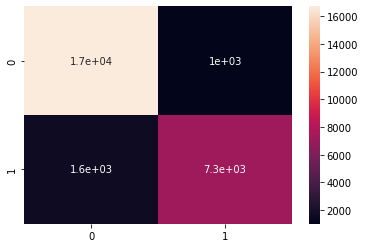

In [307]:
sns.heatmap(cf, annot=True)

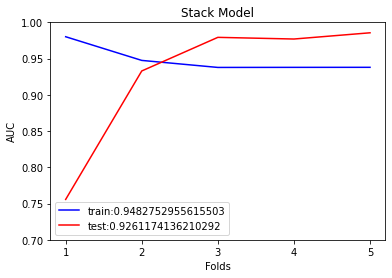

In [313]:
# K-fold curve 
AUC_b= cross_validate(stack_model, X,y, scoring='roc_auc', cv=5,return_train_score=True)
test_score = AUC_b["test_score"].reshape(5,1)
train_score = AUC_b["train_score"].reshape(5,1)
fold=[]
for i in range(0,5):
    fold = np.append(fold,i+1)
plt.title("Stack Model")
plt.plot(fold,train_score, color='blue')
plt.plot(fold,test_score, color='red')
plt.xlabel('Folds')
plt.ylabel('AUC')
plt.xticks([1, 2, 3, 4, 5])
plt.ylim([0.7, 1])
plt.legend(['train:%s' % train_score.mean(), 'test:%s'% test_score.mean()])
plt.show()

<module 'matplotlib.pyplot' from 'C:\\Users\\wajih.arfaoui_ieseg_\\AppData\\Roaming\\Python\\Python310\\site-packages\\matplotlib\\pyplot.py'>

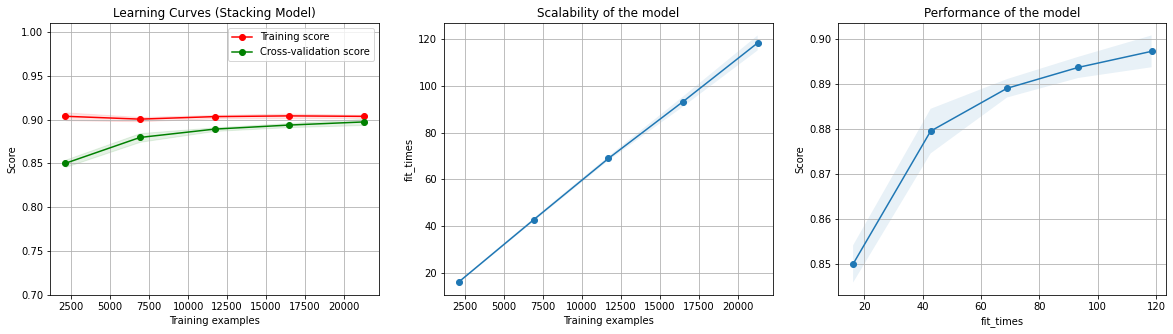

In [316]:
# Learning curve 
title = "Learning Curves (Stacking Model)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
plot_learning_curve(
    stack_model, title, X, y, axes=None, ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

### 3.6 Predicting

In [317]:
stack_pred = stack_model.predict_proba(X_test)
stack_prob = pd.DataFrame(stack_pred[:,1], columns=['subscribe'])

In [318]:
stack_out = pd.concat([test_id,stack_prob],axis=1, ignore_index=True)
stack_out.rename(columns={0: 'client_id', 1: 'subscribe'}, inplace=True)
stack_out.to_csv("./data/output/attempt_stack.csv",index=False)